In [16]:
import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import DataLoader


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

target_number = 5
if target_number is not None:
    indices = (mnist_dataset.targets == target_number)
    mnist_dataset = torch.utils.data.Subset(mnist_dataset, indices.nonzero().squeeze())

# Take only a fraction of the dataset
fraction = 0.3
num_total = len(mnist_dataset)
num_keep = int(num_total * fraction)
indices = torch.randperm(num_total)[:num_keep]
mnist_dataset = torch.utils.data.Subset(mnist_dataset, indices)

# Create random rotation angles for each image
num_images = len(mnist_dataset)
print(f"Number of images {num_images}")
rotation_angles = np.random.uniform(-180, 180, num_images)

# Apply random rotations
class RotatedMNIST:
    def __init__(self, dataset, angles):
        self.dataset = dataset
        self.angles = angles
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        angle = self.angles[idx]
        
        # Apply rotation using torchvision
        rotated_image = transforms.functional.rotate(image, angle)
        return rotated_image, label

# Create rotated dataset
rotated_mnist = RotatedMNIST(mnist_dataset, rotation_angles)

# Verify the shape of a sample
sample_img, sample_label = rotated_mnist[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {sample_label}")


Number of images 1626
Image shape: torch.Size([1, 28, 28])
Label: 5


In [17]:
rotated_mnist.dataset

In [18]:
len(rotated_mnist.dataset[0])

2

In [19]:
rotated_mnist.dataset[0][0].shape

torch.Size([1, 28, 28])

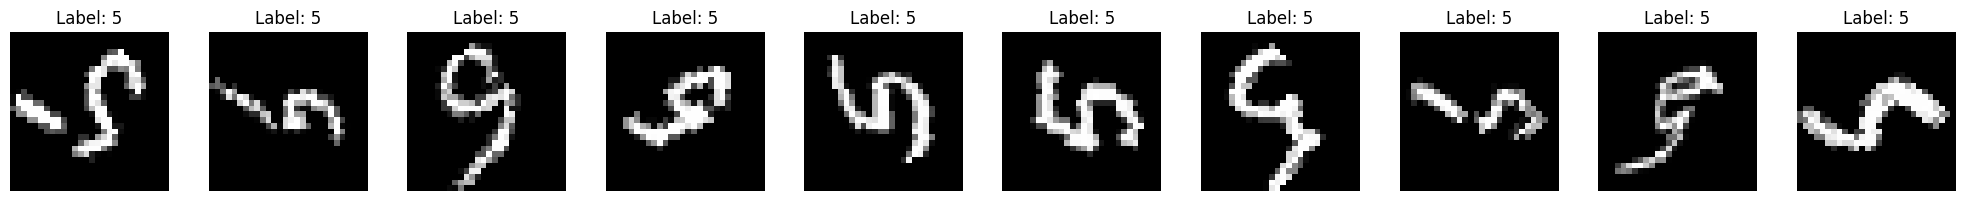

In [20]:
import matplotlib.pyplot as plt
# Create a figure with 10 subplots in one row
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

# Plot 10 sample images
for i in range(10):
    img, label = rotated_mnist[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {label}')

plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU()
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_linear(z)
        x = x.view(-1, 64, 7, 7)
        x = self.decoder_conv(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [22]:
torch.cuda.is_available()

True

Epoch 1: Loss = 430.2253
Epoch 2: Loss = 270.6710


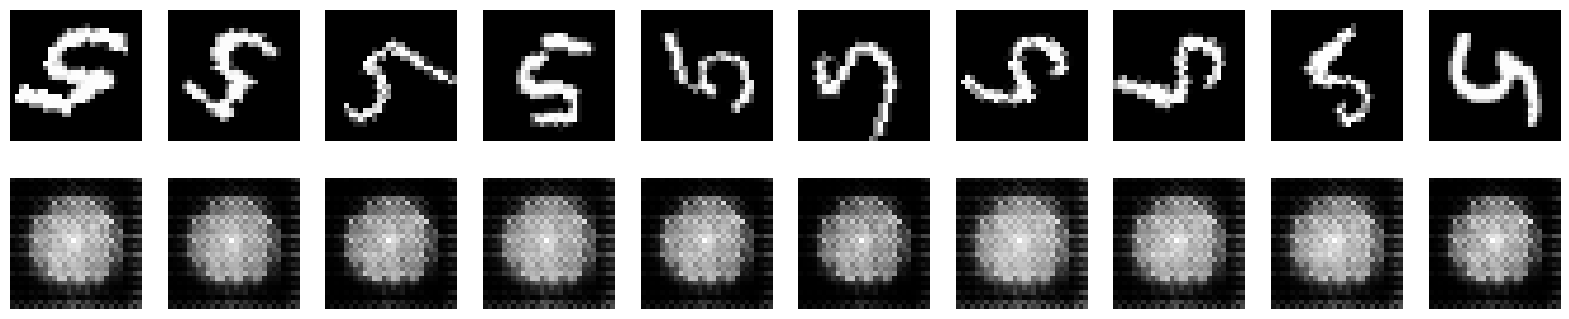

Epoch 3: Loss = 242.9150
Epoch 4: Loss = 236.1918


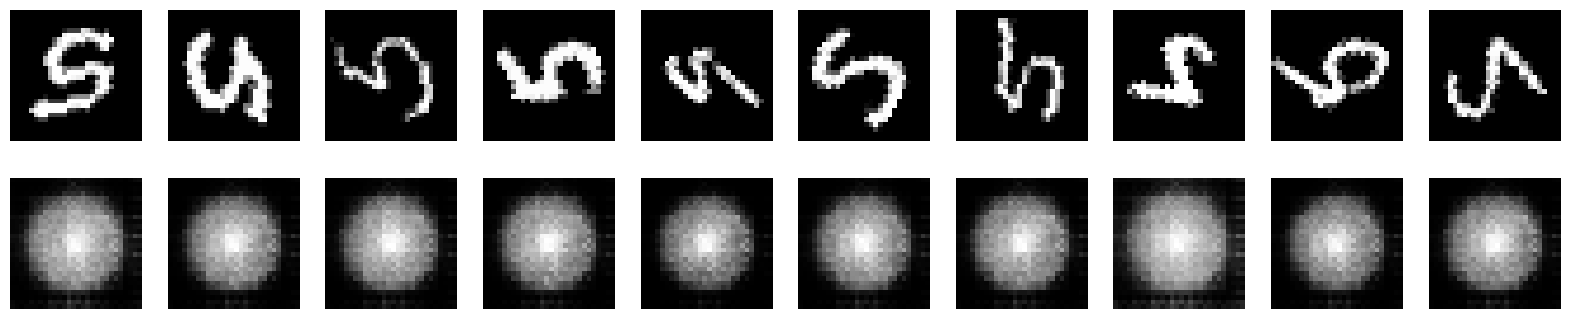

Epoch 5: Loss = 232.0253
Epoch 6: Loss = 229.0514


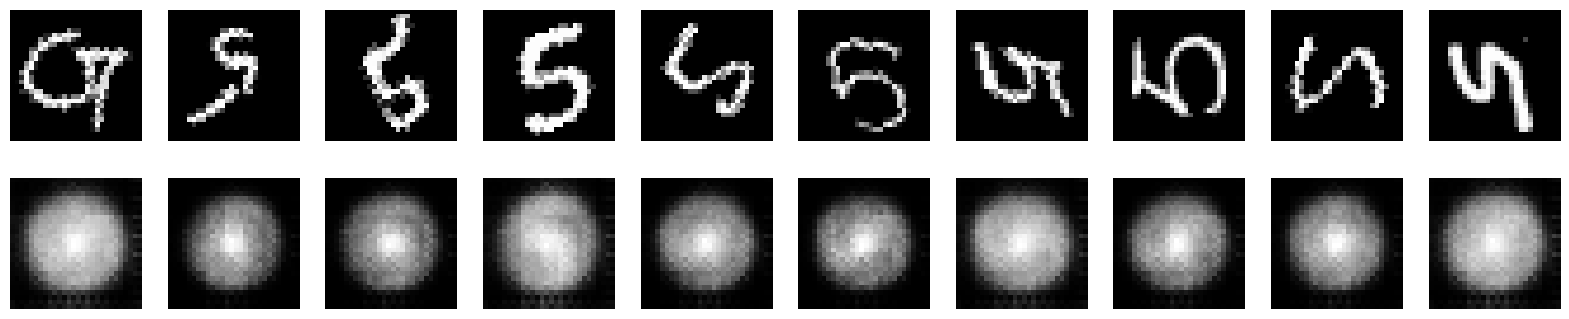

Epoch 7: Loss = 221.1803
Epoch 8: Loss = 206.6856


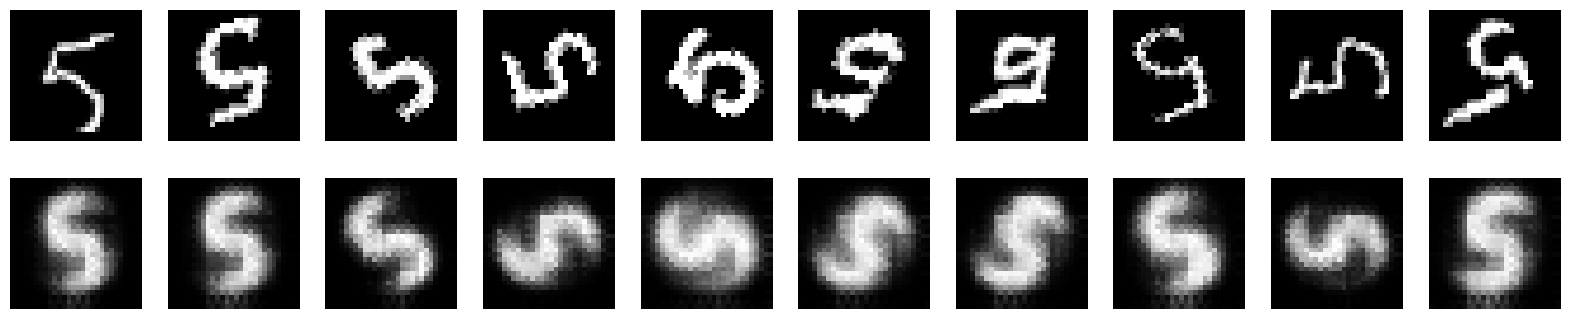

Epoch 9: Loss = 200.0097
Epoch 10: Loss = 196.9932


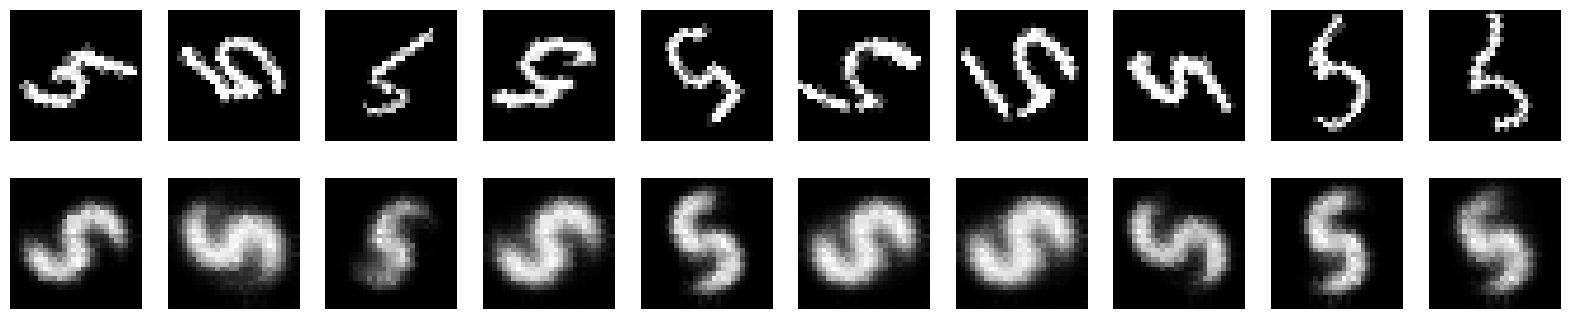

Epoch 11: Loss = 195.2490
Epoch 12: Loss = 193.5007
Epoch 13: Loss = 192.4287
Epoch 14: Loss = 190.5807
Epoch 15: Loss = 187.2719


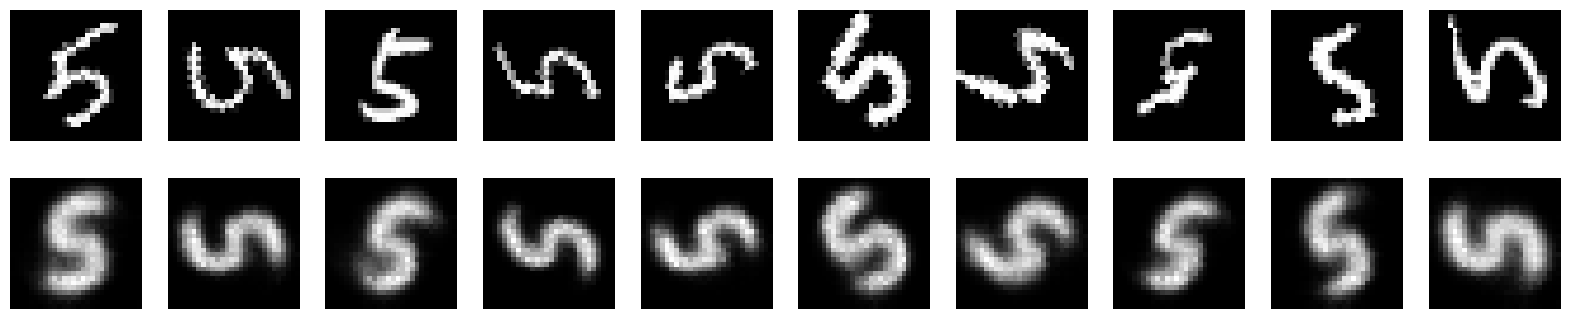

Epoch 16: Loss = 181.9509
Epoch 17: Loss = 177.2549
Epoch 18: Loss = 172.0176
Epoch 19: Loss = 167.1796
Epoch 20: Loss = 163.5627


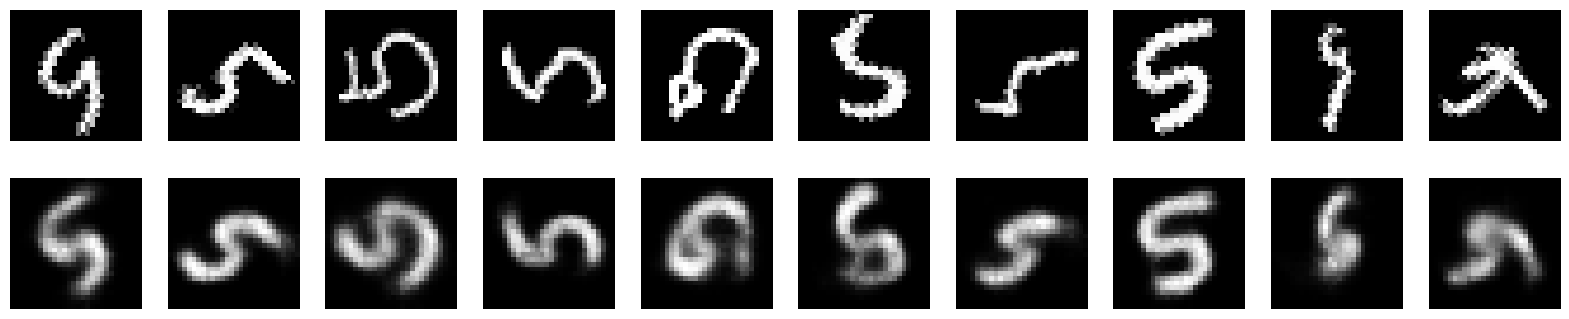

Epoch 21: Loss = 160.7019
Epoch 22: Loss = 158.1323
Epoch 23: Loss = 155.5417
Epoch 24: Loss = 152.9149
Epoch 25: Loss = 151.1549


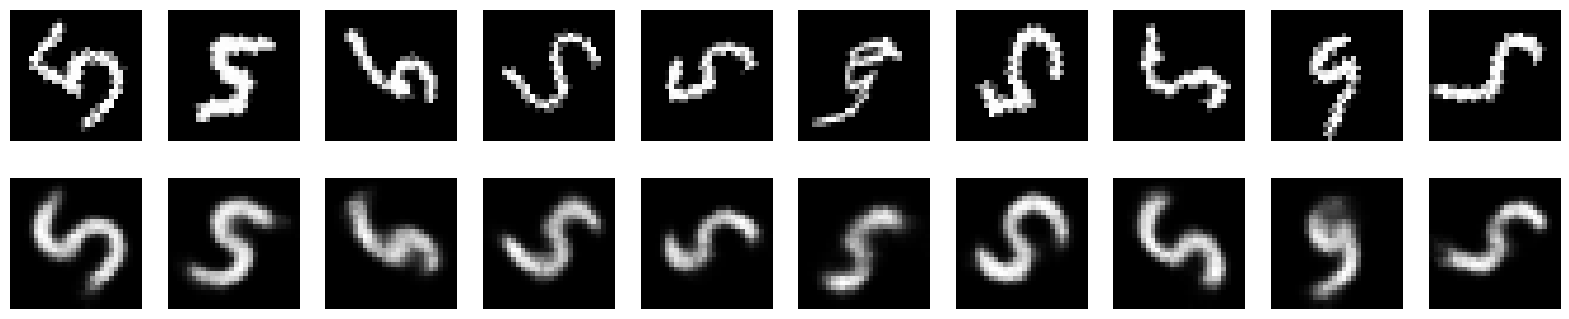

Epoch 26: Loss = 148.5896


KeyboardInterrupt: 

In [36]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(rotated_mnist, batch_size=132, shuffle=True)

# Lists to store losses
train_losses = []
recon_losses = []
kl_losses = []

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss
        loss = recon_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon / len(train_loader.dataset)
    avg_kl = total_kl / len(train_loader.dataset)
    
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    
    print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}')
    
    # Plot reconstructions every 2 or 5 epochs
    if ((epoch < 10) and (epoch + 1) % 2 == 0) or ((epoch >= 10) and (epoch + 1) % 5 == 0):
        model.eval()
        with torch.no_grad():
            # Get random samples
            data, _ = next(iter(DataLoader(rotated_mnist, batch_size=10, shuffle=True)))
            data = data.to(device)
            recon, _, _ = model(data)
            
            plt.figure(figsize=(20, 4))
            for i in range(10):
                # Original
                plt.subplot(2, 10, i + 1)
                plt.imshow(data[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
                
                # Reconstruction
                plt.subplot(2, 10, i + 11)
                plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
            plt.show()



Text(0.5, 1.0, 'Training Losses')

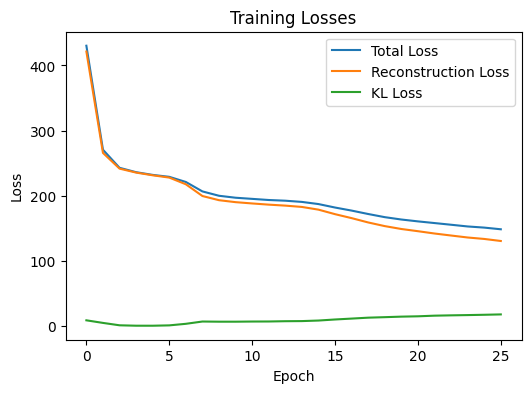

In [41]:
# Final visualization
model.eval()
plt.figure(figsize=(20, 4))

# Plot losses
plt.subplot(131)
plt.plot(train_losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')


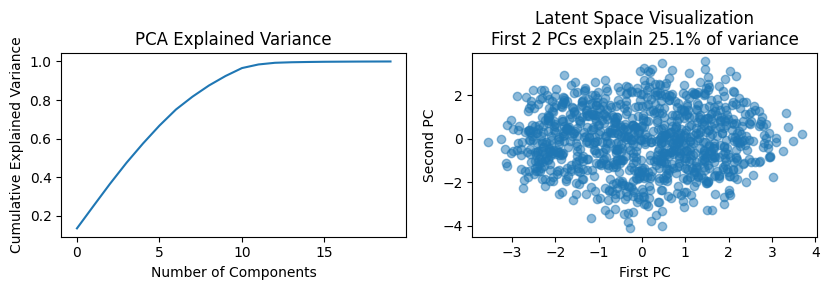

In [38]:
from sklearn.decomposition import PCA

# Get latent representations
latent_vectors = []
with torch.no_grad():
    for data, _ in DataLoader(rotated_mnist, batch_size=132):
        mu, _ = model.encode(data.to(device))
        latent_vectors.append(mu.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
# PCA analysis
pca = PCA()
pca_result = pca.fit_transform(latent_vectors)

# Plot explained variance
plt.figure(figsize=(12, 3))
plt.subplot(132)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')

# Plot first two PCs
plt.subplot(133)
plt.scatter(pca_result[:1000, 0], pca_result[:1000, 1], alpha=0.5)
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.title(f'Latent Space Visualization\nFirst 2 PCs explain {pca.explained_variance_ratio_[:2].sum():.1%} of variance')

plt.tight_layout()
plt.show()